In [91]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input

from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
#from mlxtend.plotting import plot_confusion_matrix
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_recall_fscore_support

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17466298828958160588
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10662275128840499854
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1969209021224151451
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12574021386348402759
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9530011322167790558
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8752979223602729950
physical_device_desc: "device: XLA_GPU device"
]
[]
2.3.1


## Reading Data 

In [3]:
labelsdf= pd.read_csv("worDwiseLabels/gt.csv")
labelsdf.head()

,File_name,Script,translation,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,word_1.png,Arabic,فروجنا,NaN,NaN,NaN,NaN
1,word_2.png,Arabic,المشوى,NaN,NaN,NaN,NaN
2,word_3.png,Arabic,حلال,NaN,NaN,NaN,NaN
3,word_4.png,Arabic,و,NaN,NaN,NaN,NaN
4,word_5.png,Arabic,طازج,NaN,NaN,NaN,NaN


In [4]:
labelsdf = labelsdf.dropna(axis=0, subset=['Script'])
labelsdf = labelsdf.dropna(axis=0, subset=['File_name'])
labelsdf=labelsdf[(labelsdf['Script'] !='Symbols')]
labelsdf=labelsdf[(labelsdf['Script'] !='3')]

Text(0.5, 1.0, 'number of images of each script')

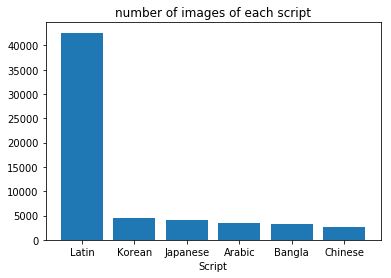

In [5]:
ab=labelsdf['Script'].value_counts()
plt.bar(ab.index,ab)
plt.xlabel('Script')
plt.title('number of images of each script')

### Balancing the imbalanced data by assigning weights to classes

##### We did weights optimization of classes using inverse frequencies of classes. We will then pass these weights to cost function of the model

In [6]:
class_index={0:'Arabic',1:'Bangla', 2:'Chinese', 3:'Japanese', 4:'Korean',5:'Latin'}

In [7]:
total=labelsdf['Script'].value_counts().sum()
vc=labelsdf['Script'].value_counts()
class_weights={val:total/vc[class_index[val]]for val in class_index}

In [8]:
class_weights

{0: 17.29928673323823,
 1: 18.865588052271313,
 2: 22.440414507772022,
 3: 14.75998052580331,
 4: 13.546470062555853,
 5: 1.4223650566515753}

### Splitting data into Train, Test and Validation 

In [10]:
labelsdf_train = labelsdf.sample(frac = 0.85) 
labelsdf_test = labelsdf.drop(labelsdf_train.index)
labelsdf_train = labelsdf_train.reset_index()




***

## Classification Report Plot function

In [86]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)


    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            if row < len(classes) and column < len(matrix[0]):
                txt = matrix[row][column]
                ax.text(column,row,matrix[row][column],va='center',ha='center')

    
    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

## Generating Train, Test and Validation Iterator using Keras ImageDataGenerator 

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)
train_it=datagen.flow_from_dataframe(
dataframe=labelsdf_train,
directory="wordWise/",
x_col="File_name",
y_col="Script",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(128,128))

In [40]:
val_it=datagen.flow_from_dataframe(
dataframe=labelsdf_train,
directory="wordWise/",
x_col="File_name",
y_col="Script",
subset="validation",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(128,128))

Found 7730 validated image filenames belonging to 6 classes.


/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [41]:
testgen=ImageDataGenerator(rescale=1./255.)
test_it=testgen.flow_from_dataframe(
dataframe=labelsdf_test,
directory="wordWise/",
x_col="File_name",
y_col="Script",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(128,128))

Found 9095 validated image filenames belonging to 6 classes.


In [42]:
freqClasses = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}

for x in test_it.classes:
    freqClasses[x] = freqClasses[x]+1
    
freqClasses

{0: 551, 1: 519, 2: 396, 3: 627, 4: 670, 5: 6332}

In [97]:
def samplesMetrics(classes, y_pred, nSamples=30):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    allPredictions = pd.DataFrame(list(zip(classes, y_pred)), columns=['Classes', 'yPredicted'])

    for i in range(nSamples):

        labelsdf_Samples= allPredictions.sample(n=500)
        #print(labelsdf_Samples)

        accuracy = accuracy_score(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'])
        accuracies.append(accuracy)
        #print(accuracy)

        metrics = precision_recall_fscore_support(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'],average='weighted')
        precisions.append(metrics[0])
        recalls.append(metrics[1])
        f1_scores.append(metrics[2])

    metricsEvaluated = {'Accuracy': accuracies,'Precision': precisions,'Recall': recalls, 'F1-Score': f1_scores}
    metricsDf = pd.DataFrame(metricsEvaluated)
    return metricsDf


def samplesMetricsFromModel(model,test_it):
    Y_pred = model.predict_generator(test_it) 
    y_pred = np.argmax(Y_pred, axis=1)
    metricsDf= samplesMetrics(test_it.classes, y_pred, nSamples=30)
    return  metricsDf

In [89]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


***

## CNN Base model

In [90]:
with strategy.scope():
    Basemodel = Sequential()

    Basemodel.add(Conv2D(32,(4, 4), activation='relu', input_shape=(128, 128, 3)))
    Basemodel.add(MaxPooling2D(pool_size=(3, 3)))

    Basemodel.add(Flatten())
    Basemodel.add(Dense(128, activation='relu'))
    Basemodel.add(Dense(6, activation='softmax'))

    Basemodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 125, 125, 32)      1568      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 41, 41, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 53792)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               6885504   
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 6,887,846
Trainable params: 6,887,846
Non-trainable params: 0
_________________________________________________________________


In [91]:
Basemodel.compile(loss = 'categorical_crossentropy',optimizer = Adam(lr = 0.001),metrics=['Recall','Precision','Accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
checkpoint = ModelCheckpoint('modelSimple3.h5',save_best_only=True,monitor='val_loss')
modelHistory=Basemodel.fit(train_it,validation_data=val_it,epochs=50,callbacks=[es,checkpoint],class_weight=class_weights)

Epoch 1/50
1369/1369 [==============================] - 280s 205ms/step - recall: 0.1998 - precision: 0.6206 - loss: 8.1249 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_recall: 0.3279 - val_loss: 1.2272 - val_precision: 0.6705
Epoch 2/50
1369/1369 [==============================] - 267s 195ms/step - recall: 0.4220 - precision: 0.7300 - loss: 5.5452 - accuracy: 4.9459e-05 - val_accuracy: 8.6244e-05 - val_recall: 0.3549 - val_loss: 1.2730 - val_precision: 0.6274
Epoch 3/50
1369/1369 [==============================] - 270s 197ms/step - recall: 0.5558 - precision: 0.7835 - loss: 4.0867 - accuracy: 2.6252e-04 - val_accuracy: 2.1561e-04 - val_recall: 0.4715 - val_loss: 1.0818 - val_precision: 0.7022
Epoch 4/50
1369/1369 [==============================] - 269s 197ms/step - recall: 0.6464 - precision: 0.8191 - loss: 3.0378 - accuracy: 0.0011 - val_accuracy: 0.0017 - val_recall: 0.6233 - val_loss: 0.9107 - val_precision: 0.7682
Epoch 5/50
1369/1369 [==============================] - 

In [42]:
#modelBase = keras.models.load_model("models/modelSimple3.h5")
modelBase = keras.models.load_model("modelSimple3.h5")

In [44]:
score = modelBase.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test loss: 0.600075364112854
Test accuracy: 0.7129191756248474


In [59]:
#Confution Matrix and Classification Report
Y_pred = modelBase.predict_generator(test_it) 
y_pred = np.argmax(Y_pred, axis=1)

cm=confusion_matrix(test_it.classes, y_pred)

In [47]:
cm

array([[ 503,   12,    0,    9,    9,   18],
       [   6,  481,    1,    2,    6,   23],
       [   0,    9,  326,   16,    9,   36],
       [  19,   27,   60,  397,   20,  104],
       [  19,   28,   17,   18,  537,   51],
       [ 258,  470,  215,  214,  231, 4944]])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

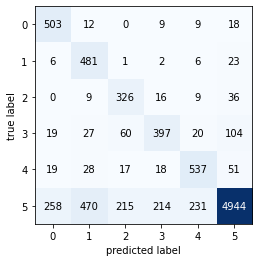

In [51]:
plot_confusion_matrix(cm)

In [53]:
basemodel_cr = classification_report(test_it.classes, y_pred)
print(basemodel_cr)

              precision    recall  f1-score   support

           0       0.62      0.91      0.74       551
           1       0.47      0.93      0.62       519
           2       0.53      0.82      0.64       396
           3       0.61      0.63      0.62       627
           4       0.66      0.80      0.72       670
           5       0.96      0.78      0.86      6332

    accuracy                           0.79      9095
   macro avg       0.64      0.81      0.70      9095
weighted avg       0.84      0.79      0.80      9095



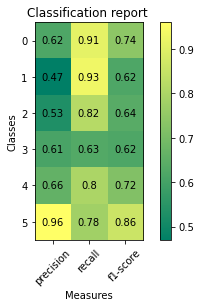

In [87]:
bm_cr = """precision    recall  f1-score   support

           0       0.62      0.91      0.74       551
           1       0.47      0.93      0.62       519
           2       0.53      0.82      0.64       396
           3       0.61      0.63      0.62       627
           4       0.66      0.80      0.72       670
           5       0.96      0.78      0.86      6332

    accuracy                           0.79      9095
   macro avg       0.64      0.81      0.70      9095
weighted avg       0.84      0.79      0.80      9095"""

plot_classification_report(bm_cr)

In [50]:
#Confution Matrix and Classification Report
Y_pred = modelBase.predict_generator(testGenList[0]) 
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [51]:
basemodel_cr = classification_report(testGenList[0].classes, y_pred)
print(basemodel_cr)

              precision    recall  f1-score   support

           0       0.64      0.94      0.76        52
           1       0.42      0.97      0.59        37
           2       0.66      0.79      0.72        42
           3       0.71      0.69      0.70        59
           4       0.60      0.80      0.69        59
           5       0.94      0.77      0.85       551

    accuracy                           0.79       800
   macro avg       0.66      0.83      0.72       800
weighted avg       0.84      0.79      0.80       800



In [88]:
model = keras.models.load_model("modelSimple3.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("SingleCNN.csv")


metricsDf

,Accuracy,F1-Score,Precision,Recall
0,0.798,0.810809,0.853785,0.798
1,0.786,0.801127,0.838719,0.786
2,0.764,0.778166,0.822821,0.764
3,0.802,0.813452,0.847676,0.802
4,0.782,0.798880,0.843002,0.782
5,0.788,0.802540,0.843411,0.788
6,0.776,0.790480,0.832629,0.776
7,0.794,0.808931,0.852649,0.794
8,0.788,0.804378,0.856905,0.788
9,0.796,0.814118,0.861434,0.796


In [93]:
def getAvgStd(csvFile,column='F1-Score'):
    df= pd.read_csv(csvFile)
    avg=np.mean(df[column])
    std=np.std(df[column])
    return avg,std
    
getAvgStd("SingleCNN.csv")

(0.8033405431346732, 0.00974796076757023)

***

## Inception Model

In [117]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

In [118]:
   
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape= (128,128,3))
x = Inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation= 'softmax')(x)
Inceptionmodel = Model(inputs = Inception_model.input, outputs =predictions )

In [120]:
Inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 63, 63, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_127[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

__________________________________________________________________________________________________
activation_157 (Activation)     (None, 6, 6, 192)    0           batch_normalization_157[0][0]    
__________________________________________________________________________________________________
activation_162 (Activation)     (None, 6, 6, 192)    0           batch_normalization_162[0][0]    
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 6, 6, 192)    0           batch_normalization_163[0][0]    
__________________________________________________________________________________________________
mixed7 (Concatenate)            (None, 6, 6, 768)    0           activation_154[0][0]             
                                                                 activation_157[0][0]             
                                                                 activation_162[0][0]             
          

In [121]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001)
Inceptionmodel.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['Recall','Precision','Accuracy'])

In [122]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
checkpoint = ModelCheckpoint('modelinception2.h5',save_best_only=True,monitor='val_loss')
historyInc=Inceptionmodel.fit(train_it,validation_data=val_it,steps_per_epoch=32,epochs=120,callbacks=[es,checkpoint])

Epoch 1/120
32/32 [==============================] - 129s 4s/step - recall: 0.5879 - precision: 0.7758 - loss: 1.2368 - accuracy: 8.1380e-04 - val_accuracy: 0.9011 - val_recall: 0.7034 - val_loss: 1828.9122 - val_precision: 0.7034
Epoch 2/120
32/32 [==============================] - 123s 4s/step - recall: 0.6094 - precision: 0.7790 - loss: 1.1197 - accuracy: 0.0000e+00 - val_accuracy: 0.6914 - val_recall: 0.0741 - val_loss: 117930.9062 - val_precision: 0.0741
Epoch 3/120
32/32 [==============================] - 128s 4s/step - recall: 0.6348 - precision: 0.8217 - loss: 1.0143 - accuracy: 0.0000e+00 - val_accuracy: 0.7866 - val_recall: 0.6977 - val_loss: 136.5722 - val_precision: 0.7030
Epoch 4/120
32/32 [==============================] - 127s 4s/step - recall: 0.6084 - precision: 0.8329 - loss: 1.0081 - accuracy: 0.0000e+00 - val_accuracy: 0.0329 - val_recall: 0.6955 - val_loss: 4.5241 - val_precision: 0.7027
Epoch 5/120
32/32 [==============================] - 123s 4s/step - recall: 0.

Epoch 72/120
32/32 [==============================] - 123s 4s/step - recall: 0.7207 - precision: 0.8367 - loss: 0.6594 - accuracy: 0.0000e+00 - val_accuracy: 0.3284 - val_recall: 0.6780 - val_loss: 36.1372 - val_precision: 0.7601
Epoch 73/120
32/32 [==============================] - 123s 4s/step - recall: 0.7607 - precision: 0.8589 - loss: 0.6085 - accuracy: 0.0000e+00 - val_accuracy: 0.0358 - val_recall: 0.7484 - val_loss: 2.3132 - val_precision: 0.7897
Epoch 74/120
32/32 [==============================] - 123s 4s/step - recall: 0.7227 - precision: 0.8438 - loss: 0.7025 - accuracy: 0.0000e+00 - val_accuracy: 0.8231 - val_recall: 0.6884 - val_loss: 1213.5813 - val_precision: 0.7069
Epoch 75/120
32/32 [==============================] - 123s 4s/step - recall: 0.7061 - precision: 0.8216 - loss: 0.7385 - accuracy: 0.0000e+00 - val_accuracy: 0.4878 - val_recall: 0.6717 - val_loss: 303.1238 - val_precision: 0.7478
Epoch 76/120
32/32 [==============================] - 123s 4s/step - recall: 0

Epoch 108/120
32/32 [==============================] - 123s 4s/step - recall: 0.7910 - precision: 0.8852 - loss: 0.4775 - accuracy: 0.0000e+00 - val_accuracy: 0.0244 - val_recall: 0.8019 - val_loss: 10.8996 - val_precision: 0.8539
Epoch 109/120
32/32 [==============================] - 123s 4s/step - recall: 0.7373 - precision: 0.8658 - loss: 0.5904 - accuracy: 0.0000e+00 - val_accuracy: 0.0195 - val_recall: 0.7783 - val_loss: 4.0676 - val_precision: 0.8852
Epoch 110/120
32/32 [==============================] - 123s 4s/step - recall: 0.8047 - precision: 0.8986 - loss: 0.4638 - accuracy: 0.0000e+00 - val_accuracy: 0.0020 - val_recall: 0.7802 - val_loss: 1.0995 - val_precision: 0.8834
Epoch 111/120
32/32 [==============================] - 123s 4s/step - recall: 0.7568 - precision: 0.8708 - loss: 0.5717 - accuracy: 0.0000e+00 - val_accuracy: 3.2342e-04 - val_recall: 0.7739 - val_loss: 0.6327 - val_precision: 0.8771
Epoch 112/120
32/32 [==============================] - 123s 4s/step - recal

In [97]:
Inceptionmodel = keras.models.load_model("models/modelinception2.h5")

In [99]:
score = Inceptionmodel.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.5693820714950562
Test recall: 0.7844969630241394


In [100]:
#Confution Matrix and Classification Report
Y_predInception = Inceptionmodel.predict(test_it) 
Y_predInception = np.argmax(Y_predInception, axis=1)
inception_cm=confusion_matrix(test_it.classes, Y_predInception)


In [101]:
inception_cm

array([[ 419,    1,    0,    8,   13,  110],
       [   4,  362,    0,    6,   11,  136],
       [   4,    4,   58,  197,   11,  122],
       [   7,    9,   25,  268,   32,  286],
       [  16,    1,   12,   43,  378,  220],
       [  88,   24,    2,   87,   40, 6091]])

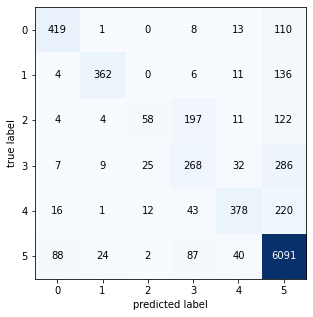

In [102]:
plot_confusion_matrix(inception_cm,figsize=(5,5))
plt.show()

In [103]:
inception_cr = classification_report(test_it.classes, Y_predInception)
print(inception_cr)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       551
           1       0.90      0.70      0.79       519
           2       0.60      0.15      0.24       396
           3       0.44      0.43      0.43       627
           4       0.78      0.56      0.65       670
           5       0.87      0.96      0.92      6332

    accuracy                           0.83      9095
   macro avg       0.73      0.59      0.63      9095
weighted avg       0.82      0.83      0.82      9095



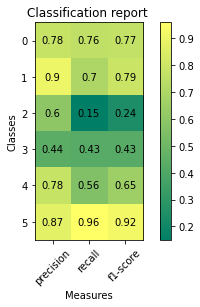

In [104]:
inception_Cr = """ precision    recall  f1-score   support

           0       0.78      0.76      0.77       551
           1       0.90      0.70      0.79       519
           2       0.60      0.15      0.24       396
           3       0.44      0.43      0.43       627
           4       0.78      0.56      0.65       670
           5       0.87      0.96      0.92      6332

    accuracy                           0.83      9095
   macro avg       0.73      0.59      0.63      9095
weighted avg       0.82      0.83      0.82      9095"""

plot_classification_report(inception_Cr)

In [100]:
model = keras.models.load_model("modelinception2.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("Inception.csv")


metricsDf

,Accuracy,F1-Score,Precision,Recall
0,0.832,0.818309,0.816565,0.832
1,0.850,0.836373,0.840681,0.850
2,0.848,0.833558,0.830384,0.848
3,0.846,0.829967,0.833365,0.846
4,0.834,0.821240,0.817894,0.834
5,0.860,0.849966,0.847915,0.860
6,0.844,0.831497,0.834447,0.844
7,0.848,0.833500,0.831723,0.848
8,0.838,0.819530,0.814764,0.838
9,0.832,0.813555,0.806911,0.832


In [101]:
getAvgStd("Inception.csv")

(0.8225007067894545, 0.009912450328277807)

***

## ResNet Model

In [105]:
with strategy.scope():    
    Resnet_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape= (128,128,3))
    x = Resnet_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(6, activation= 'softmax')(x)
    Resnetmodel = Model(inputs = Resnet_model.input, outputs =predictions )
    Resnetmodel.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [106]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001)
Resnetmodel.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['Recall','Precision','Accuracy'])

In [107]:
es = EarlyStopping(monitor='val_recall', mode='min', verbose=1,patience=20)
checkpoint = ModelCheckpoint('modelinResnet3.h5',save_best_only=True,monitor='val_loss')
historyRes=Resnetmodel.fit(train_it,validation_data=val_it,epochs=120,steps_per_epoch=32,callbacks=[es,checkpoint])

Epoch 1/120
32/32 [==============================] - 294s 9s/step - recall: 0.4936 - precision: 0.7394 - loss: 1.3533 - accuracy: 0.0125 - val_accuracy: 0.9011 - val_recall: 0.7034 - val_loss: 333.4337 - val_precision: 0.7034
Epoch 2/120
32/32 [==============================] - 284s 9s/step - recall: 0.5732 - precision: 0.7384 - loss: 1.6389 - accuracy: 0.0143 - val_accuracy: 0.6848 - val_recall: 0.0543 - val_loss: 588.0438 - val_precision: 0.0543
Epoch 3/120
32/32 [==============================] - 292s 9s/step - recall: 0.5762 - precision: 0.7421 - loss: 1.1303 - accuracy: 0.0060 - val_accuracy: 0.0000e+00 - val_recall: 0.7034 - val_loss: 7.1855 - val_precision: 0.7034
Epoch 4/120
32/32 [==============================] - 279s 9s/step - recall: 0.6113 - precision: 0.7524 - loss: 1.1095 - accuracy: 0.0054 - val_accuracy: 0.0000e+00 - val_recall: 0.7034 - val_loss: 1.1424 - val_precision: 0.7034
Epoch 5/120
32/32 [==============================] - 281s 9s/step - recall: 0.6533 - precisi

In [88]:
Resnetmodel = keras.models.load_model("models/modelinResnet3.h5")

In [89]:
#modelRes = keras.models.load_model("modelinResnet2.h5")
score = Resnetmodel.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.46175417304039
Test accuracy: 0.8295766711235046


In [90]:
#Confution Matrix and Classification Report
Y_pred = Resnetmodel.predict_generator(test_it) 
y_predRes = np.argmax(Y_pred, axis=1)

#print('Confusion Matrix')
resnet_cm=confusion_matrix(test_it.classes, y_predRes)

In [91]:
resnet_cm

array([[ 446,    2,    1,    1,    4,   97],
       [   0,  411,    0,    0,    1,  107],
       [   3,    7,   84,  121,   28,  153],
       [   6,   28,   24,  197,   36,  336],
       [  12,    6,    2,   14,  421,  215],
       [  35,   58,    3,   23,   34, 6179]])

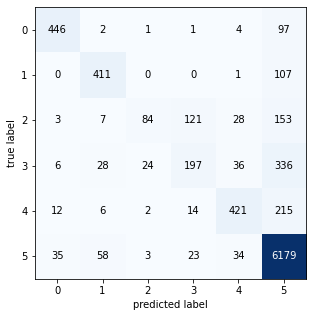

In [93]:
plot_confusion_matrix(resnet_cm,figsize=(5,5))
plt.show()

In [94]:
resnet_cr = classification_report(test_it.classes, y_predRes)
print(resnet_cr)

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       551
           1       0.80      0.79      0.80       519
           2       0.74      0.21      0.33       396
           3       0.55      0.31      0.40       627
           4       0.80      0.63      0.71       670
           5       0.87      0.98      0.92      6332

    accuracy                           0.85      9095
   macro avg       0.78      0.62      0.67      9095
weighted avg       0.84      0.85      0.83      9095



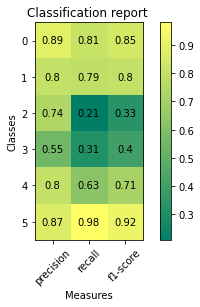

In [96]:
resnet_cr = """precision    recall  f1-score   support

           0       0.89      0.81      0.85       551
           1       0.80      0.79      0.80       519
           2       0.74      0.21      0.33       396
           3       0.55      0.31      0.40       627
           4       0.80      0.63      0.71       670
           5       0.87      0.98      0.92      6332

    accuracy                           0.85      9095
   macro avg       0.78      0.62      0.67      9095
weighted avg       0.84      0.85      0.83      9095"""

plot_classification_report(resnet_cr)


In [98]:
model = keras.models.load_model("modelinResnet3.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("Resnet.csv")


metricsDf

/home/lkgupta/my_project_dir/my_project_env/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,F1-Score,Precision,Recall
0,0.882,0.860604,0.845138,0.882
1,0.866,0.841488,0.860085,0.866
2,0.872,0.849348,0.869373,0.872
3,0.878,0.857325,0.879185,0.878
4,0.870,0.846902,0.863599,0.870
5,0.880,0.860873,0.874512,0.880
6,0.880,0.860729,0.877061,0.880
7,0.884,0.864823,0.880783,0.884
8,0.866,0.844068,0.863159,0.866
9,0.856,0.829712,0.811341,0.856


In [99]:
getAvgStd("Resnet.csv")

(0.8569284619684553, 0.010262804461824506)